In [1]:
# Purpose: Comparing global ocean heat content changes from my new IAF
#          simulation to the observations, CMIP and OMIP-2 data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 18. 05. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m
from cartopy.util import add_cyclic_point

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "

from dask.distributed import Client
client = Client(n_workers=4)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Load in Levitus et al. (2012) and Cheng et al. (2016) data

CPU times: user 573 ms, sys: 250 ms, total: 823 ms
Wall time: 1.27 s


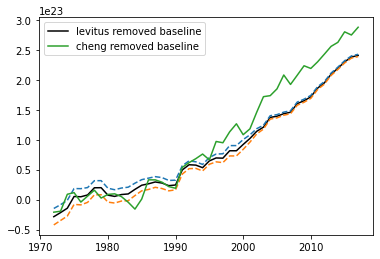

In [2]:
%%time
# (1) load Cheng et al., 2016 0-2000 m observed OHC 

base = '/g/data/e14/mv7494/'
fname = 'OHC2000m_annual_timeseries.txt'

cheng = np.loadtxt(base+fname, delimiter=' ', skiprows=18)
cheng = cheng[31:-2,1] * 1e21 # select only 1972 to 2017 and convert to
cheng = cheng - np.mean(cheng[0:8]) # remove 1972-1981 baseline period

# (2) load Levitus et al., 2012 0-2000 m observed OHC -> calculate 5-month running mean        # taking 5-month centered running mean
levitus = xr.open_dataset('/g/data/e14/mv7494/heat_content_anomaly_0-2000_pentad.nc',decode_times=False).pent_h22_WO.dropna('time')[-46:]    # main data set
levitus = (levitus - np.mean(levitus[0:9]))*1e22 # remove the 1972-1981 baseline and multiply by *1e22 as stated in the metadata
levitus_se = xr.open_dataset('/g/data/e14/mv7494/heat_content_anomaly_0-2000_pentad.nc',decode_times=False).pent_h22_se_WO.dropna('time')[-46:]*1e22 # standard error
# levitus_se = levitus_se - np.mean(levitus_se[0:9]) # remove the 1972-1981 baseline

levitus_shading = np.zeros(shape=(len(levitus),4)) # empty array which I then fill up
                                                   # four columns: time, data, upper uncertainty, lower uncertainty
levitus_shading[:,0] = np.linspace(1972,2017,46) # first column = year data
levitus_shading[:,1] = levitus # remove the 1972-1981 baseline
for f in range(len(levitus)):
    levitus_shading[f,2] = levitus_shading[f,1] + levitus_se[f] # data + standard error 
    levitus_shading[f,3] = levitus_shading[f,1] - levitus_se[f] # data - standard error 
plt.plot(levitus_shading[:,0], levitus_shading[:,1], c='k', label='levitus removed baseline')
plt.plot(levitus_shading[:,0], levitus_shading[:,2], linestyle='--')
plt.plot(levitus_shading[:,0], levitus_shading[:,3], linestyle='--')
plt.plot(levitus_shading[:,0], cheng, label='cheng removed baseline'); plt.legend()
# I choose this 9-year period as it ends just before the eruption of El Chichón in April to September 1982 

### Load SODA

In [3]:
# %%time
# rho_0 = 1035 # kg m-3
# C_p = 3992.1 # J kg-1 K-1
# temp = xr.open_mfdataset('/g/data/ua8/SODA/v3-12-2/grid_05/mon/soda3.12.2_mn_ocean_reg_*.nc').temp[0,0,:,:].fillna(0) # replace all nan with zeroes

# landsea_mask = temp.where(temp>=0,1).where(temp<=0,1) # replace all non-zero data with ones
# landsea_mask = landsea_mask.where(landsea_mask !=0) # replace all zeroes by NAN
# landsea_mask # nice!

# # create custom area_t for SODA with a resolution of 0.5° latitude x 0.5° longitude (330, 720)
# dimensions = [330, 720]


# dyt_SODA = np.full(dimensions[0], (6371e3*np.pi)/dimensions[0])   # half the circumference of the Earth divided by number of lat grids
# dxt_SODA = np.full(dimensions[1], (6371e3*2*np.pi)/dimensions[1]) # circumference of the Earth divided by the number of lon grid cells


# a = np.linspace(-np.pi/2, np.pi/2,dimensions[0])
# for l in range(dimensions[0]):
#     dyt_SODA[l] = np.cos(a[l]) * dyt_SODA[l] # scale with cosine of latitude
  
# aa, bb = np.meshgrid(dxt_SODA,dyt_SODA) # create meshgrid

# os.system('rm -r /g/data/e14/mv7494/SODA/SODA_grid.nc')
# (landsea_mask*aa*bb).to_dataset(name='area_t').to_netcdf('/g/data/e14/mv7494/SODA/SODA_grid.nc') # SODA area

# (landsea_mask*aa*bb).plot(); plt.title(' ')

In [4]:
# %%time
# depth = xr.open_mfdataset('/g/data/ua8/SODA/v3-12-2/grid_05/mon/soda3.12.2_mn_ocean_reg_*.nc').st_ocean
# area_t = xr.open_dataset('/g/data/e14/mv7494/SODA/SODA_grid.nc').area_t
# SODA_temp = xr.open_mfdataset('/g/data/ua8/SODA/v3-12-2/grid_05/mon/soda3.12.2_mn_ocean_reg_*.nc').temp

# SODA = (rho_0*C_p*area_t*depth*SODA_temp).isel(st_ocean=slice(0,34)).sum(['st_ocean','xt_ocean','yt_ocean']).groupby('time.year').mean('time')
# SODA = SODA - SODA[0:12].mean() # remove the 1980-1992 baseline
# (SODA).plot()
# # Walltime: 44 s

### Load in 2000-year PI-Offset ACCESS-OM2-1 data and calculate OHC 0-2000 m through time series

CPU times: user 3.12 s, sys: 925 ms, total: 4.04 s
Wall time: 29.3 s


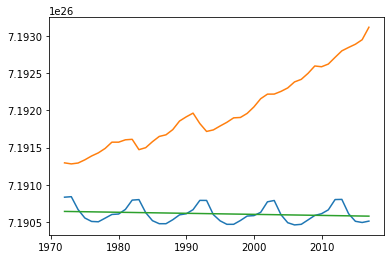

In [5]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['1deg_jra55_rdf_branch2000_Control_PI_Offset/', '1deg_jra55_iaf_branch2000_PI_Offset/']
rho_0 = 1035 # kg m-3
C_p = 3992.1 # J kg-1 K-1

# temp_ctrl = linear trend in the control simulation
temp_ctrl = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
temp = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
dzt = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[1]+'output200/ocean/ocean_grid.nc').area_t

temp_ctrl['time'] = temp.time # copy over time dimension so I can subtract the drift
# calculate OHC
OHC_ctrl = (rho_0*C_p*temp_ctrl*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])
OHC = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])

time = np.linspace(1972,2017,46)
plt.plot(time,OHC_ctrl.values)
plt.plot(time,OHC.values)

# calculate linear trend in the control and then subtract it
idx = np.isfinite(OHC_ctrl.values)
z1 = np.polyfit(time[idx], OHC_ctrl.values[idx], 1) # only consider the non-NAN values

# z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time,p1(time))
# # subtract the linear trend in the control and plot the anomalous ACCESS-OM2-1 0-2000 m OHC
OHC_access = OHC.values - p1(time)
OHC_access_pi = OHC_access-np.nanmean(OHC_access[0:9]) # remove the 1972-1981 baseline
# Wall time: 33.9 s

### Extending the time series back to 1958
Using output198 and output199 from the transitional spin-up period

CPU times: user 456 ms, sys: 17.5 ms, total: 473 ms
Wall time: 2.74 s


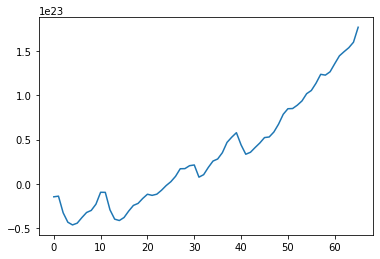

In [6]:
%%time
temp = xr.open_mfdataset(base + '1deg_jra55_rdf_spinup_PI_Offset_extending_SI_Figure/' + 'output*/ocean/ocean.nc').temp
dzt = xr.open_mfdataset(base+'1deg_jra55_rdf_spinup_PI_Offset_extending_SI_Figure/' + 'output*/ocean/ocean.nc').dzt

OHC = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])
OHC = OHC.values # ok, looks good. However I messed up the time axis, the date in output198 to output199 should be 1952-01-01 to 1971-12-31
OHC = OHC - p1(np.linspace(1952,1971,20)) # remove the linear trend in the control
OHC = OHC - np.mean(OHC_access[0:9]) #remove the 1972-1981 baseline
OHC_extended = np.append(OHC,OHC_access_pi) # combining both 1952-1971 and 1972-2017 time series

plt.plot(OHC_extended) # nice, this is what I was expecting!

### Load in 500-year PI-Offset ACCESS-OM2-1 data and calculate OHC 0-2000 m through time series

CPU times: user 2.6 s, sys: 162 ms, total: 2.76 s
Wall time: 21.3 s


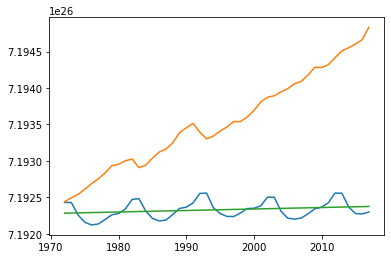

In [7]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['1deg_jra55_rdf_branch500_PI_Offset_Control/', '1deg_jra55_iaf_branch500_PI_Offset/']
rho_0 = 1035 # kg m-3
C_p = 3992.1 # J kg-1 K-1

# temp_ctrl = linear trend in the control simulation
temp_ctrl = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
temp = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
dzt = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[1]+'output051/ocean/ocean_grid.nc').area_t

temp_ctrl['time'] = temp.time # copy over time dimension so I can subtract the drift
# calculate OHC
OHC_ctrl = (rho_0*C_p*temp_ctrl*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])
OHC = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])

time = np.linspace(1972,2017,46)
plt.plot(time,OHC_ctrl.values)
plt.plot(time,OHC.values)

# calculate linear trend in the control and then subtract it
idx = np.isfinite(OHC_ctrl.values)
z1 = np.polyfit(time[idx], OHC_ctrl.values[idx], 1) # only consider the non-NAN values

# z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time,p1(time))
# # subtract the linear trend in the control and plot the anomalous ACCESS-OM2-1 0-2000 m OHC
OHC_access = OHC.values - p1(time)
OHC_access_pi500 = OHC_access-np.nanmean(OHC_access[0:9]) # remove the 1972-1981 baseline
# Wall time: 33.9 s

### Load in ACCESS-OM2-1 data and calculate OHC 0-2000 m through time series

CPU times: user 2.37 s, sys: 128 ms, total: 2.5 s
Wall time: 21.2 s


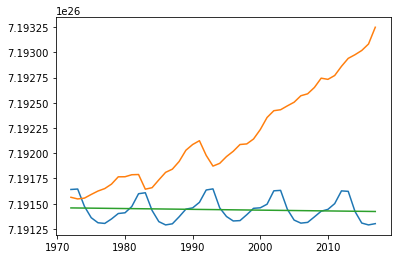

In [8]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'
run = ['1deg_jra55_rdf_branch2000_Control/', '1deg_jra55_iaf_branch2000/']
rho_0 = 1035 # kg m-3
C_p = 3992.1 # J kg-1 K-1

# temp_ctrl = linear trend in the control simulation
temp_ctrl = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
temp = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12'))
dzt = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[1]+'output201/ocean/ocean_grid.nc').area_t

temp_ctrl['time'] = temp.time # copy over time dimension so I can subtract the drift
# calculate OHC
OHC_ctrl = (rho_0*C_p*temp_ctrl*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])
OHC = (rho_0*C_p*temp*area_t*dzt).sel(st_ocean=slice(0.,2000.)).sum(['xt_ocean','yt_ocean','st_ocean'])

time = np.linspace(1972,2017,46)
plt.plot(time,OHC_ctrl.values)
plt.plot(time,OHC.values)

# calculate linear trend in the control and then subtract it
idx = np.isfinite(OHC_ctrl.values)
z1 = np.polyfit(time[idx], OHC_ctrl.values[idx], 1) # only consider the non-NAN values

# z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time,p1(time))
# # subtract the linear trend in the control and plot the anomalous ACCESS-OM2-1 0-2000 m OHC
OHC_access = OHC.values - p1(time)
OHC_access = OHC_access-np.nanmean(OHC_access[0:9]) # remove the 1972-1982 baseline
# Wall time: 13.5 s

# OHC_access = bn.move_mean(OHC_access, window=5, min_count=1) # create 5-month running mean

### Load in ACCESS-OM2-1 data from Hakase's 5-cycle and calculate OHC 0-2000 m

In [9]:
%%time
### load in 1deg IAF SPIN-UP FROM ANDREW KISS
# -------------------------------------------------------------------------------------
# c = '/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle/output*/ocean/ocean.nc'   

# temp = xr.open_mfdataset(c).temp.isel(time=slice(14,60)) - 273.15 # ok, the time axis goes from 2198 to 2257
# dzt  = xr.open_mfdataset(c).dzt.isel(time=slice(14,60)) # ok, the time axis goes from 2198 to 2257
# area_t = xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1/output000/ocean/ocean_grid.nc').area_t

# OHC_1deg_AEK = (rho_0*C_p*temp*area_t*dzt).isel(st_ocean=slice(0,35)).sum(['xt_ocean','yt_ocean','st_ocean']).values
# OHC_1deg_AEK

### Load in 1deg IAF SPIN-UP FROM HAKASE HAYASHIDA
# # -------------------------------------------------------------------------------------
base_omip = '/g/data/ik11/outputs/access-om2/' # read in the new omip simulations from ryan

a6 = ['%03d' % i for i in np.linspace(183,365,183)]


# empty list which I fill up each iteration    
c6 = []

for b in [4,5,6]:
    for i in range(61): # loop through the number of files I would like to open
        c6.append(i) # append the list
        if b == 4:
            c6[i]     = base_omip + '1deg_jra55_iaf_omip2_cycle'+str(b)+'/output' + a6[i] + '/ocean/ocean_month.nc'
        if b == 5: 
            c6[i+61]  = base_omip + '1deg_jra55_iaf_omip2_cycle'+str(b)+'/output' + a6[i+61] + '/ocean/ocean_month.nc'
        if b == 6: 
            c6[i+122] = base_omip + '1deg_jra55_iaf_omip2_cycle'+str(b)+'/output' + a6[i+122] + '/ocean/ocean_month.nc'

# open all the files which are part of the list
temp4 = xr.open_mfdataset(c6,decode_times = True).temp
temp5 = xr.open_mfdataset(c6,decode_times = True).temp
temp6 = xr.open_mfdataset(c6,decode_times = True).temp
dzt = xr.open_mfdataset(c6,decode_times = True).dht
area_t = xr.open_mfdataset(base_omip + '1deg_jra55_iaf_omip2_cycle1/output000/ocean/ocean_grid.nc',decode_times = True).area_t

OHC_1deg_HH_c4 = (rho_0*C_p*temp4*area_t*dzt).isel(st_ocean=slice(0,35)).sum(['xt_ocean','yt_ocean','st_ocean']).groupby('time.year').mean('time').load()
OHC_1deg_HH_c5 = (rho_0*C_p*temp5*area_t*dzt).isel(st_ocean=slice(0,35)).sum(['xt_ocean','yt_ocean','st_ocean']).groupby('time.year').mean('time').load()
OHC_1deg_HH_c6 = (rho_0*C_p*temp6*area_t*dzt).isel(st_ocean=slice(0,35)).sum(['xt_ocean','yt_ocean','st_ocean']).groupby('time.year').mean('time').load()
# Wall time: 14min 59s

CPU times: user 2min 38s, sys: 5.57 s, total: 2min 43s
Wall time: 4min 15s


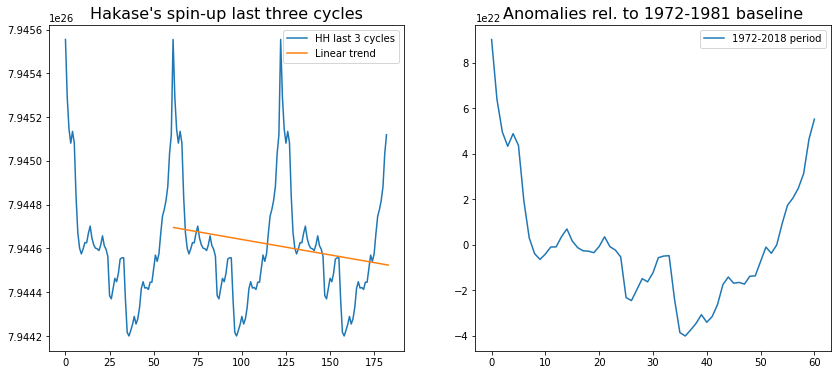

In [10]:
OHC_1deg_HH = np.zeros(183); t = np.linspace(0,183,183)

OHC_1deg_HH[0:61] = OHC_1deg_HH_c4
OHC_1deg_HH[61:122] = OHC_1deg_HH_c5
OHC_1deg_HH[122:183] = OHC_1deg_HH_c5

# fit a 1st degree polynomial to the last three cycles
z1 = np.polyfit(t[-122:], OHC_1deg_HH[-122:], 1)
# stat1 = stats.linregress(t,OHC_1deg_HH)# get the statistical values
p1 = np.poly1d(z1) # construct the polynomial 


fig= plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(OHC_1deg_HH, label='HH last 3 cycles'); plt.plot(t[-122:],p1(t[-122:]), label='Linear trend'); plt.legend()
plt.title('Hakase\'s spin-up last three cycles', fontsize=16)

OHC_1deg_HH_last3cycles = OHC_1deg_HH # make a copy of the time series for plotting later one while the original time series is 
                                      # now being overwritten by the anomalous time series of the last cycle after having removed the
                                      # linear trend of cycles 4-6

plt.subplot(1,2,2)
OHC_1deg_HH = OHC_1deg_HH[-61:] - p1(t[-61:]) # remove linear trend over the last two cycles
                                   # 121-182 is the last 61 years of the final, 6th cycle (i. e., 1958-2018)
                                   # 122-183 is the 60-year period from 1958-2018

OHC_1deg_HH = OHC_1deg_HH - np.mean(OHC_1deg_HH[14:23]) # removing the 1972-1981 baseline
plt.plot(OHC_1deg_HH, label='1972-2018 period'); plt.legend()
plt.title('Anomalies rel. to 1972-1981 baseline', fontsize=16)

# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'OHC_time_series_and_trend_last_three_cycles_HH_OMIP-2', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 4min 57s

# Why is it now suddenly stuck and is still running at 25 minutes? 

### save the time series as a .txt file so I don't have to re-run this part again

In [11]:
np.savetxt('/g/data/e14/mv7494/OHC_1deg_HH.txt',OHC_1deg_HH)

### Load in the five cycles, calculate linear trend through cycles 3-5 and remove that for the anomalies

In [12]:
# %%time
# import cosima_cookbook as cc
# session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
# expt = '1deg_jra55v13_iaf_spinup1_B1'
# temp = cc.querying.getvar(expt, 'temp', session, 'ocean.nc') - 273.15 # convert to deg_C
# # temp = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1/output*/ocean/ocean.nc').temp
# dzt  =  cc.querying.getvar(expt, 'dzt', session, 'ocean.nc')
# area_t = xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1/output000/ocean/ocean_grid.nc').area_t
# rho_0 = 1035 # kg m-3
# C_p = 3992.1 # J kg-1 K-1

# OHC_1deg_AEK_up = (rho_0*C_p*temp*area_t*dzt).isel(st_ocean=slice(0,35)).sum(['xt_ocean','yt_ocean','st_ocean']).values
# # 43.7 s

In [13]:
# cy35_up = OHC_1deg_AEK_up[119:-1]

# # fit a 1st degree polynomial to the 1962-71 data
# t = np.linspace(119,300,180)


# idx = np.isfinite(cy35_up)
# z1 = np.polyfit(t[idx], cy35_up[idx], 1) # only consider the non-NAN values
# stat1 = stats.linregress(t,cy35_up)# get the statistical values
# p1 = np.poly1d(z1) # construct the polynomial 

# t2 = np.linspace(0,46,46)

# OHC_1deg_AEK = OHC_1deg_AEK - p1(t2) # remove the linear trend in the 3rd to 5th cycle
# OHC_1deg_AEK = OHC_1deg_AEK - np.nanmean(OHC_1deg_AEK[0:9]) # remove 1972-1981 baseline
# # OHC_1deg_AEK = bn.move_mean(OHC_1deg_AEK, window=5, min_count=1) # 5-month running mean
# plt.plot(OHC_1deg_AEK, label='AEK'); plt.legend()

### Load in Taimoor & Damien's CMIP6 data

In [14]:
%%time
# rolling mean over five time steps
a = xr.open_dataset('/g/data/e14/mv7494/OHC_2000m_CMIP6.nc', decode_times=True).dropna('y')

length=43
cmip = np.empty([length, 25])
cmip_shading = np.zeros(shape=(length,5)) # empty array which I then fill up
cmip_shading[:,0] = np.linspace(1972,2014,43) # first column = year data
                                              # second column = mean
for i in range(25): # loop through the ensembles
    b = a.OHC_2000m[i].values[2:] # select 1972-2014 for each ensemble
    b = b - np.mean(b) # remove the mean
    b = b - np.mean(b[2:11]) # remove baseline 1972-1981
    cmip[:,i] = b # save in allocated array
for j in range(length): # loop through the years
    cmip_shading[j,1] = np.mean(cmip[j,:])   # ensemble mean
    cmip_shading[j,2] = np.min(cmip[j,:])   # min of all ensembles per time step
    cmip_shading[j,3] = np.max(cmip[j,:])   # max of all ensembles per time step    
    cmip_shading[j,4] = np.std(cmip[j,:])   # standard deviation of all ensembles per time step

CPU times: user 21.5 ms, sys: 151 µs, total: 21.6 ms
Wall time: 22.8 ms


### Load in OMIP-2 data

--- calculating FSU-HYCOM ---
--- calculating MIROC-COCO4.9 ---
--- calculating CAS-LICOM3 ---
--- calculating AWI-FESOM ---
--- calculating CESM-POP ---
--- calculating NorESM-BLOM ---
--- calculating MRI.COM ---
--- calculating EC-Earth3-NEMO ---
--- calculating Kiel-NEMO ---
--- calculating GFDL-MOM ---
--- calculating CMCC-NEMO ---
CPU times: user 2.09 s, sys: 221 ms, total: 2.31 s
Wall time: 2.52 s


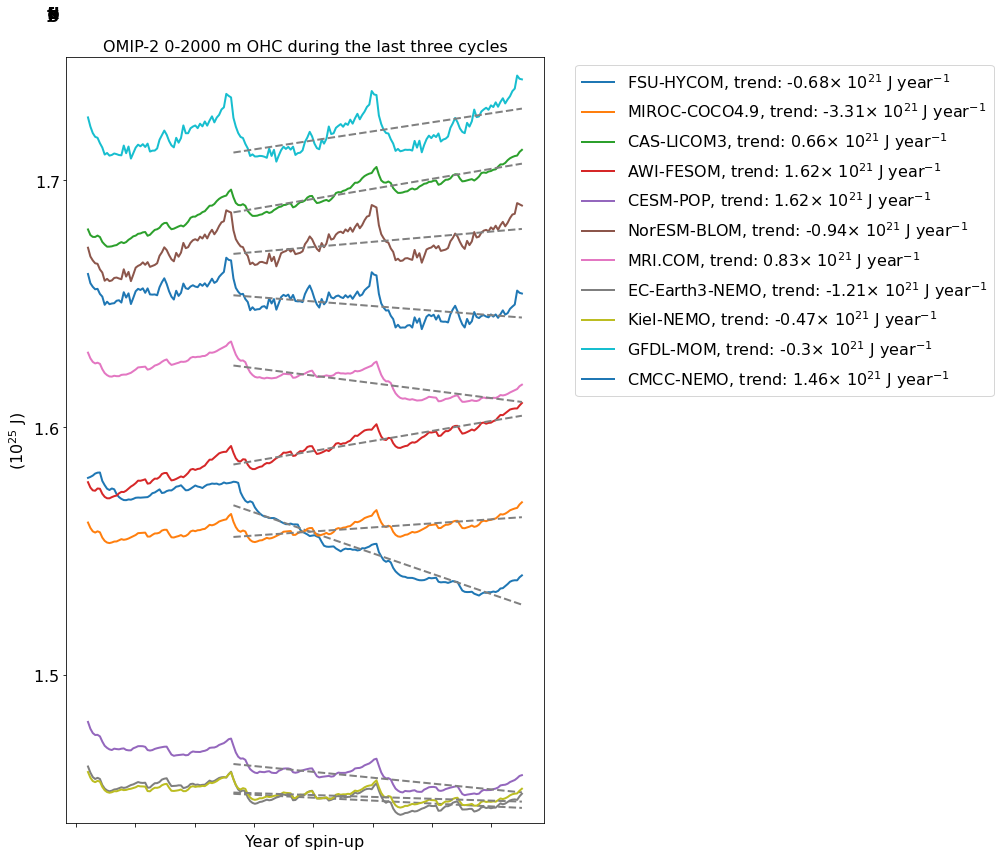

In [15]:
%%time
path = ['FSU-HYCOM/20190917/', 
        'MIROC-COCO4.9/20190917/JRA/', 
        'CAS-LICOM3/20190917/', 
        'AWI-FESOM/20190927/OMIP2/loop', 
        'CESM-POP/20190917/omip2/', 
        'NorESM-BLOM/20190917/', 
        'MRI.COM/20190912/omip2/', 
        'EC-Earth3-NEMO/20191128/OMIP2_new_realization/loop', 
        'Kiel-NEMO/20190927/GEOMAR05.JRAbgc/', 
        'GFDL-MOM/20191003/OMIP2/', 
        'CMCC-NEMO/20191109/OMIP2/']
fname = ['thetao_0-2000_t_allcycles_jra55_fsu.nc',
         'thetaoga_2000.nc', 
         'OMIP2_thetao_0-2000_001To366_annual.nc', 
         'thetao_0_2000_Oyr_FESOM1.4_historical_loop', 
         'thetaoga_Oyr_CESM2_omip2_r1i1p1f1_gn_2000m_0001-0366.nc', 
         'thetao_0-2000_OMIP2_20190730.nc',
         'thetaoga_0-2000.nc',
         'thetao_0_2000_GLOSST_Index_Omon_EC-Earth3_omip1_r1i1p1f1_gn_1958-2018.nc',
         'GEOMAR05.JRAbgc-cycle',
         'annual_thetao_0_2000m_allcycles_JRA.nc',
         'OMIP2.1d_CMCC_1y_thetaoga_0-2000_1653_2018.nc']
varname = ['thetao', 
          'thetaoga',
           'thetaoga',
           'thetao',
           'thetaoga',
           'thetao',
           'thetaoga',
           'thetao_0_2000_GLOSST_Index',
           'thetaoga',
           'thetao',
           'thetaoga'] 

OHC_2000m_omip = np.zeros((183,len(path)+1))
OHC_2000m_omip_anom = np.zeros((61,len(path)+1))
OHC_2000m_omip[:,0] = np.linspace(180,363,183) # first column = year of spin-up 
OHC_2000m_omip_anom[:,0] = np.linspace(1958,2018,61) 

# ocean volumes directly copied from Tsujino et al. (2020) script:
var_list = [ "thetaoga_700", "thetaoga_2000", "thetaoga_2000_bottom", "thetaoga_all" ]
volume_list = np.array([ 2.338e17, 6.216e17, 7.593e17, 1.381e18 ])
# degC_to_ZJ = volume_list * 3.99e3 * 1.036e3 * 1.0e-21

for i in range(11): # loop through the various models
    print('--- calculating ' + path[i][:path[i].index('/')] + ' ---')
    

    # Spezialfälle hier weil die 6 JRA55-do cycles immer im Jahr 1958 anfangen statt kontinuierlich 360 Jahre lang

    # --- special case: CAS-LICOM3 model --- #
    if i == 3:
        for l in [4,5,6]:
            thetao = xr.open_mfdataset('/g/data/e14/mv7494/OMIP-2_data/' + path[i] + str(l) + '/'+ fname[i] + str(l) + '_gr_195801-201812.nc', 
                                       decode_times=True)[varname[i]]   
            OHC = (rho_0 * C_p * thetao * volume_list[1]) # select 1958-2017 period
            
            OHC_2000m_omip[len(OHC)*(l-4):len(OHC)*(l-3),i+1] = OHC # write into the dataframe           

    # --- special case: EC-Earth3-NEMO model --- #
    if i == 7:
        for l in [4,5,6]:
                                                                                                                  # here lon and lat have coordinates 0 -> because 
                                                                                                                  # they are global, so I can remove/squeeze 
                                                                                                                  # those empty coordinates
            thetao = xr.open_mfdataset('/g/data/e14/mv7494/OMIP-2_data/' + path[i] + str(l) + '/'+ fname[i], decode_times=True)[varname[i]][:,0,0]  
            OHC = (rho_0 * C_p * thetao * volume_list[1]) # select 1958-2017 period
       
            OHC_2000m_omip[len(OHC)*(l-4):len(OHC)*(l-3),i+1] = OHC # write into the dataframe
    

    # --- special case: KIEL-NEMO model --- #
    if i == 8:
        for l in [4,5,6]:
            thetao = xr.open_mfdataset('/g/data/e14/mv7494/OMIP-2_data/' + path[i] + fname[i] + str(l) + '_1y_19580101_20181231_thetaoga_0-2000.nc', 
                                       decode_times=True)[varname[i]][:,0,0]
            OHC = (rho_0 * C_p * thetao * volume_list[1]) # select 1958-2017 period
            
            OHC_2000m_omip[len(OHC)*(l-4):len(OHC)*(l-3),i+1] = OHC # write into the dataframe             
            
        

    if i in [0,1,2,4,5,6,9,10]:
        thetao = xr.open_mfdataset('/g/data/e14/mv7494/OMIP-2_data/' + path[i] + fname[i], decode_times=False)[varname[i]]
   
        time = np.linspace(0,183,183)
        OHC = (rho_0 * C_p * thetao * volume_list[1])[-183:]
        OHC = OHC[-183:] # the last three cycles consisting of 1958-2018
        OHC_2000m_omip[:,i+1] = OHC.values # write values into data frame
        

    # calculate linear trend over the last three cycles and remove that trend from the data to calculate anomalies
    z1 = np.polyfit(time, OHC_2000m_omip[:,i+1], 1) # only consider the non-NAN values
    # z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
    p1 = np.poly1d(z1) # construct the polynomial
    OHC_anom = OHC_2000m_omip[:,i+1] - p1(time)    

    OHC_anom = OHC_anom[-61:] # select 1972-2018
    OHC_anom = OHC_anom - np.mean(OHC_anom[14:24]) # remove 1972-1981 baseline
  
    

    
    OHC_2000m_omip_anom[:,i+1] = OHC_anom  
    
  

# calculate the mean for the OMIP-2 models
OHC_2000m_omip_shading = np.zeros((61,5))
OHC_2000m_omip_shading[:,0] = np.linspace(1958,2018,61) 


for f in range(61):
    OHC_2000m_omip_shading[f,1] = np.mean(OHC_2000m_omip_anom[f,1:]) # ensemble mean
    OHC_2000m_omip_shading[f,2] = np.min(OHC_2000m_omip_anom[f,1:]) # ensemble minima per time step
    OHC_2000m_omip_shading[f,3] = np.max(OHC_2000m_omip_anom[f,1:]) # ensemble maxima per time step
    OHC_2000m_omip_shading[f,4] = np.std(OHC_2000m_omip_anom[f,1:]) # standard deviation per time step 


# ------------------------------------------------------------------------ #
#                  ---- plotting routine from here ----                    #
# ------------------------------------------------------------------------ #

fig= plt.figure(figsize=(14,12),tight_layout=True,facecolor='w',edgecolor='k')
ax1 = plt.subplot(1,1,1)
for i in range(11):

    plt.title('OMIP-2 0-2000 m OHC during the last three cycles', fontsize=16)
    plt.plot(OHC_2000m_omip[:,0],OHC_2000m_omip[:,i+1]/1e25, linewidth=2,
            label = path[i][:path[i].index('/')] + 
            ', trend: '+str(np.round(p1[1]/1e21,2))+r'$\times$ 10$^{21}$ J year$^{-1}$') # plot the trend
    
    # adding the polynomial fit through the last two cycles
    z1 = np.polyfit(OHC_2000m_omip[-122:,0], OHC_2000m_omip[-122:,i+1], 1) # only consider the non-NAN values
    p1 = np.poly1d(z1) # construct the polynomial 
    plt.plot(OHC_2000m_omip[-122:,0],p1(OHC_2000m_omip[-122:,0])/1e25, linewidth=2, linestyle='--', color='grey')

    
    #     plt.text(200, 1.46, str(p1[1]))

    ax1.text(-.04, 1.05,string.ascii_lowercase[i], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    #plt.title('World Ocean heat content 0-2000 m', fontsize=16) # title
    plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
    # ticklabel  size
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    ax1.yaxis.offsetText.set_fontsize(16)
    ax1.yaxis.major.formatter._useMathText = True # use scientific notation
    if i in range(8): ax1.set_xticklabels([])
    plt.locator_params(axis='y', nbins=6);
    plt.ylim([1.44,1.75])

plt.xlabel('Year of spin-up', fontsize=16); plt.ylabel('(10$^{25}$ J)', fontsize=16)

# adding ACCESS-OM2 data
# plt.plot(OHC_2000m_omip[:,0],OHC_1deg_HH_last3cycles/1e25, label='HH last 3 cycles'); 
#     plt.plot(OHC_2000m_omip[:,0],p1(OHC_2000m_omip[:,0]), label='Linear trend'); plt.legend()
    
# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'OHC_time_series_and_trend_last_three_cycles_OMIP-2_models', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 23.4 s

### Load in full OHC from Hakase's run

In [16]:
# %%time
# ### Load in 1deg IAF SPIN-UP FROM HAKASE HAYASHIDA
# # # -------------------------------------------------------------------------------------
# base_omip = '/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle' # read in the new omip simulations

# # open all the files which are part of each cycle
# OHC_1deg_HH_c1 = xr.open_mfdataset(base_omip + '1/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# OHC_1deg_HH_c2 = xr.open_mfdataset(base_omip + '2/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# OHC_1deg_HH_c3 = xr.open_mfdataset(base_omip + '3/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# OHC_1deg_HH_c4 = xr.open_mfdataset(base_omip + '4/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# OHC_1deg_HH_c5 = xr.open_mfdataset(base_omip + '5/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# OHC_1deg_HH_c6 = xr.open_mfdataset(base_omip + '6/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# # Wall time: 32.8 s

# OHC_1deg_HHfull = np.zeros(366); t = np.linspace(0,366,366)

# OHC_1deg_HHfull[0:61]    = OHC_1deg_HH_c1
# OHC_1deg_HHfull[61:122]  = OHC_1deg_HH_c2
# OHC_1deg_HHfull[122:183] = OHC_1deg_HH_c3
# OHC_1deg_HHfull[183:244] = OHC_1deg_HH_c4
# OHC_1deg_HHfull[244:305] = OHC_1deg_HH_c5
# OHC_1deg_HHfull[305:366] = OHC_1deg_HH_c6


# # fit a 1st degree polynomial to the last three cycles
# z1 = np.polyfit(t[183:366], OHC_1deg_HHfull[183:366], 1)
# stat1 = stats.linregress(t,OHC_1deg_HHfull)# get the statistical values
# polyHH = np.poly1d(z1) # construct the polynomial 

# fig= plt.figure(figsize=(12,4))
# ax1 = plt.subplot(1,1,1)
# plt.plot(OHC_1deg_HHfull, label='ACCESS-OM2', c=rotblau[3]); plt.plot(t[183:366],polyHH(t[183:366]), label='Linear trend last three cycles', linestyle='--', c=rotblau[17])
# plt.legend(fontsize=16, loc='lower left')
# plt.title('Total OHC in the OMIP-2 spin-up', fontsize=16)
# # trend value 
# plt.text(200, 1.93, str(np.round(polyHH[1]*1e25/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=15, 
#          horizontalalignment = 'left', color = rotblau[17])
# plt.xlabel('Year', fontsize=16); ax1.set_ylabel('(10$^{23}$ J)', fontsize=16)
# plt.xticks(fontsize=16); plt.yticks(fontsize=16)

# # --- saving as 300 dpi .PNG image in specified folder ------------------------
# plt.savefig(save + 'OHC_time_series_OMIP-2_ACCESS-OM2', dpi=300, facecolor='w', 
#             edgecolor='w', orientation='landscape', papertype=None, 
#             format=None, transparent=False, bbox_inches=None, 
#             pad_inches=0.1, metadata=None)
# # %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Wall time: 23.4 s
# # Wall time: 4min 31s

### Plotting routine together with the CMIP6 data

CPU times: user 1.9 s, sys: 163 ms, total: 2.06 s
Wall time: 1.92 s


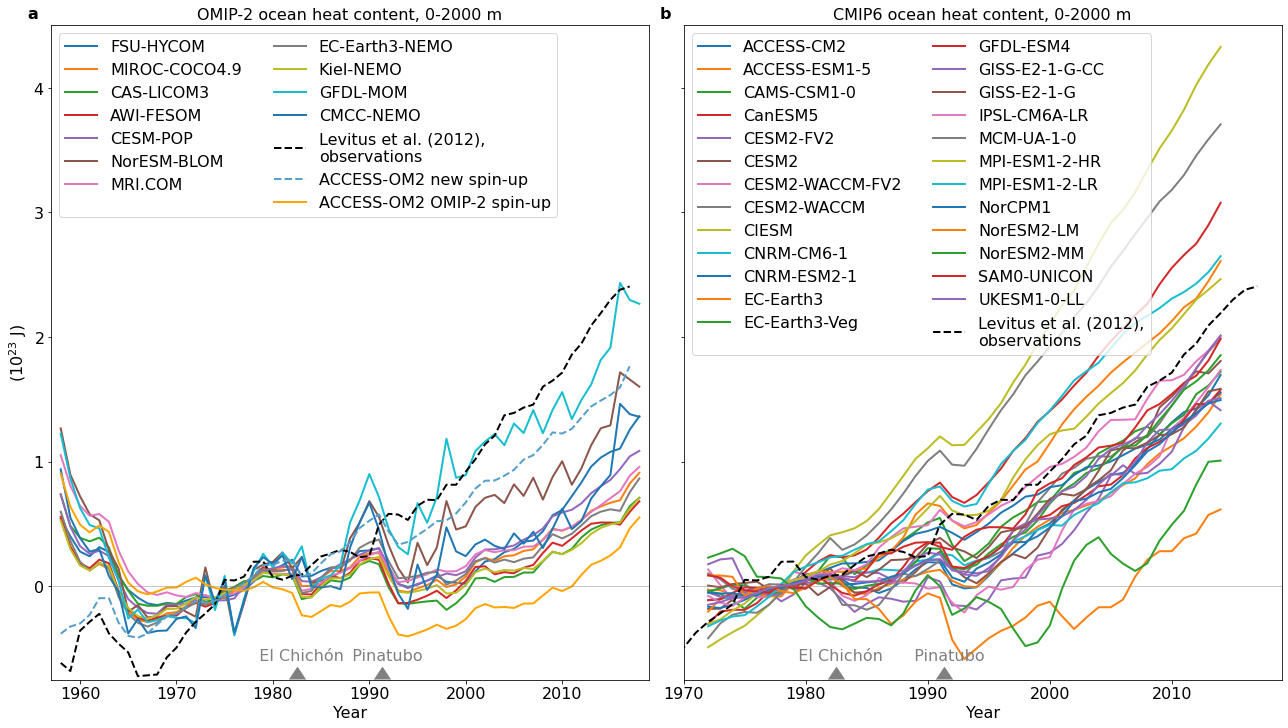

In [17]:
%%time
# get the levitus et al. (2012) data again, but this time the full time period 1950-2017
levitus2 = xr.open_dataset('/g/data/e14/mv7494/heat_content_anomaly_0-2000_pentad.nc',decode_times=False).pent_h22_WO.dropna('time')*1e22
levitus2 = levitus2[1:] # 1958-2017 period
levitus2 = levitus2 - np.mean(levitus2[14:23]) # remove the mean over the 1972-1981 baseline

fig= plt.figure(figsize=(18,14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2, height_ratios=[1,2.5]) 

# --- panel a) -------------------------------------------------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[1,0]) # plot 1 spans all subplots on first row

for i in range(11):
    plt.plot(OHC_2000m_omip_anom[:,0],OHC_2000m_omip_anom[:,i+1]/1e23, linewidth=2, label = str(path[i][:path[i].index('/')])) # plot the time series
plt.plot(np.linspace(1958,2017,len(levitus2)),levitus2/1e23, c = 'k', label = 'Levitus et al. (2012),\nobservations', linewidth=2, linestyle='--')
plt.plot(np.linspace(1958,2017,60),OHC_extended[6:]/1e23, c = rotblau[15], label = 'ACCESS-OM2 new spin-up', linewidth=2, linestyle='--')
plt.plot(np.linspace(1958,2018,61), OHC_1deg_HH/1e23, linewidth=2, label = 'ACCESS-OM2 OMIP-2 spin-up', color='orange') # plot ACCESS-OM2 as well


plt.xlabel('Year', fontsize=16); ax1.set_ylabel('(10$^{23}$ J)', fontsize=16)

plt.title('OMIP-2 ocean heat content, 0-2000 m', fontsize=16) # title

# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16)
ax1.yaxis.major.formatter._useMathText = True # use scientific notation
plt.legend(fontsize=16, ncol=2, loc='upper left')
ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)

# plot volcano markers
plt.plot(1982.45, -.65, marker=6, markersize=16, color = 'grey')
plt.plot(1991.33, -.65, marker=6, markersize=16, color = 'grey')

# add fancy label for volcanoes
plt.text(1982.45, -.6, '  El Chichón', color = 'grey', fontsize = 16, horizontalalignment = 'center')
plt.text(1991.33, -.6, '  Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'center')

# reference lines for volcano eruption
# ax1.axvline(1982, color='grey'); ax1.axvline(1991, color='grey')

ax1.text(-.04, 1.01,string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
plt.xlim(1957,2019); plt.ylim(-1,4.5) # axis limits
# plt.text(1972, .4, 'baseline:\n1972-1981', color = 'grey', fontsize = 16, horizontalalignment = 'left')
plt.ylim(bottom = -.75)

# --- panel b) -------------------------------------------------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[1,1]) # plot 1 spans all subplots on first row
time_cmip = np.linspace(1972,2014,43)
for i in range(25):
    # preparing the string for the legends
    s = str(a.OHC_2000m.model[i]) # get string of model
    #   find(start   )     (start  )        (end      )
    s = s[s.find('array(')+len('array('):s.rfind(', dtype')][1:-1] # extract only the model name, i.e. the part between start and end
    
    plt.plot(time_cmip,cmip[:,i]/1e23, label = s, linewidth=2) # plot the actual CMIP6 model
plt.plot(np.linspace(1958,2017,len(levitus2)),levitus2/1e23, c = 'k', label = 'Levitus et al. (2012),\nobservations', linewidth=2, linestyle='--')
   
plt.legend(fontsize = 16, ncol = 2)
plt.xlabel('Year', fontsize=16)

plt.title('CMIP6 ocean heat content, 0-2000 m', fontsize=16) # title


# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16)
ax1.yaxis.major.formatter._useMathText = True # use scientific notation
plt.legend(fontsize=16, ncol=2)
ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)

# plot volcano markers
plt.plot(1982.45, -.65, marker=6, markersize=16, color = 'grey')
plt.plot(1991.33, -.65, marker=6, markersize=16, color = 'grey')

# add fancy label for volcanoes
plt.text(1982.45, -.6, '  El Chichón', color = 'grey', fontsize = 16, horizontalalignment = 'center')
plt.text(1991.33, -.6, '  Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'center')

# reference lines for volcano eruption
# ax1.axvline(1982, color='grey'); ax1.axvline(1991, color='grey')

ax1.text(-.04, 1.01,string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
plt.xlim(1970,2019); plt.ylim(-1,4.5) # axis limits
ax1.set_yticklabels([])
# plt.text(1972, .75, 'baseline:\n1972-1981', color = 'grey', fontsize = 16, horizontalalignment = 'left')
plt.ylim(bottom = -.75)

# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'OHC_time_series_OMIP-2_and_CMIP6_models', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 23.4 s

### Calculating the +/- 2 sigma range for both OMIP and CMIP6

In [ ]:
%%time
# ---- OMIP-2
sdev = np.std(OHC_2000m_omip_anom)
plt.subplot(1,2,1)
for i in range(11):
    plt.plot(OHC_2000m_omip_anom[:,0],OHC_2000m_omip_anom[:,i+1], linewidth=1, label = str(path[i][:path[i].index('/')]), c='grey') # plot the time series
plt.plot(OHC_2000m_omip_anom[:,0], OHC_2000m_omip_shading[:,1], linestyle='--', linewidth=2, color=rotblau[1]) # mean
mean = OHC_2000m_omip_shading[:,1]
plt.fill_between(OHC_2000m_omip_anom[:,0], OHC_2000m_omip_shading[:,1]+(2*OHC_2000m_omip_shading[:,4]), 
                 OHC_2000m_omip_shading[:,1]-(2*OHC_2000m_omip_shading[:,4]), 
                 alpha=0.2, color=rotblau[5], linewidth=.1) # shading with +/- 2 standard deviations
plt.title('OMIP-2')

# ---- CMIP6
plt.subplot(1,2,2)
# this plot confirms all I do is correct, nice!
for i in range(25):
    # preparing the string for the legends   
    plt.plot(cmip_shading[:,0],cmip[:,i], c = 'grey', linewidth=1) # plot the actual CMIP6 model
sdev_cmip = np.std(cmip)     # calculate sigma
plt.plot(cmip_shading[:,0], cmip_shading[:,1], linestyle='--', linewidth=2, color=rotblau[20])
plt.fill_between(cmip_shading[:,0], cmip_shading[:,1]+(2*cmip_shading[:,4]), cmip_shading[:,1]-(2*cmip_shading[:,4]), 
                 alpha=0.2, color=rotblau[15], linewidth=.1) # shading with +/- 2 standard deviations
plt.title('CMIP6')

In [ ]:
plt.plot(OHC_2000m_omip_shading[:,1]+2*OHC_2000m_omip_shading[:,4], label = 'OMIP-2 + 2$\sigma$')
plt.plot(OHC_2000m_omip_shading[:,1], label = 'OMIP-2 MMM')
plt.plot(OHC_2000m_omip_shading[:,1]-2*OHC_2000m_omip_shading[:,4], label = 'OMIP-2 - 2$\sigma$'); plt.legend(fontsize=16)

### Combining the first plot with the Argo comparison for 2006-2013

In [ ]:
%%time
# with CDO prepare linear trend of temperature values after I have already removed the linear trend 
# in the control simulation
base = '/g/data/e14/mv7494/access-om2/archive/'

start_time = ['2006']; end_time = ['2017']


run = ['1deg_jra55_rdf_branch2000_Control/', '1deg_jra55_rdf_branch2000_Control_PI_Offset/', '1deg_jra55_iaf_branch2000/', '1deg_jra55_iaf_branch2000_PI_Offset/']
out = '1deg_jra55_iaf_branch2000_trend/'
exp = ['clim','clim_PI_Offset','iaf','iaf_PI_Offset']

# merging CTRL output, selecting the years 1972-2017 and selecting temp

for c in [1]:#range(2): # loop through the two control simulations, iaf_Control and iaf_Control_PI_Offset
    print(run[c])
    # select temp, years and create linear trend from that data
    cdo.selvar('temp', input = '-selyear,'+start_time[0]+'/'+end_time[0]+
               ' -mergetime ' + base + run[c] + 'output*/ocean/ocean_month.nc',
               output = base + out + 'temp_'+exp[c]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc', force=False)
    cdo.trend(input='-selyear,'+start_time[0]+'/'+end_time[0]+' '+
              base + out + 'temp_'+exp[c]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc',
              output= base + out + 'intercept_temp_'+exp[c]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
              base + out + 'trend_temp_'+exp[c]+'_'+start_time[0]+'-'+end_time[0]+'.nc',force=False)    
print('-------------------------------------------'); print(' ') # print output to see the progress of the calculations
# Walltime: 34 min for one control run if files do not already exist


for e in [3]:
    if e == 3:
        print('In this part of the loop, clim_PI_Offset gets removed')
        print(run[e])
        print('-------------------------------------------')
        ctrl_run = exp[1] # clim_PI_Offset        

    # (I) merging IAF output, selecting the years 1972-2017 and selecting temp
    cdo.selvar('temp', input = '-selyear,'+start_time[0]+'/'+end_time[0]+
               ' -mergetime ' + base + run[e] + 'output*/ocean/ocean_month.nc',
               output = base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc', force=False)
    # Walltime: 2min 34s

    # (III) removing the linear trend in the CTRL from the IAF data
    #       -> cdo subtrend ifile afile bfile ofile
    cdo.subtrend(input= base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc '+
                 base + out + 'intercept_temp_'+ctrl_run+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                 base + out + 'trend_temp_'+ctrl_run+'_'+start_time[0]+'-'+end_time[0]+'.nc',
                 output= base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc', force=False)
    # Walltime: 24 s

    # (IV) creating intercept and linear trend from the data in step III over different time periods
    for f in range(1): # for full loop: f in range(4): cycles over 1972-2017, 2006-2013,1993-2017 and 2006-2017 periods
        os.system('rm -r '+base + out + 'trend_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc')
        cdo.trend(input='-selyear,'+start_time[f]+'/'+end_time[f]+' '+
                  base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc',
                  output= base + out + 'intercept_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc '+
                  base + out + 'trend_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc',force=False)

    if exp[e] != 'iaf': # remove all intercepts except for the iaf simulation. I need this one later on for the check
        os.system('rm -r '+base + out + 'intercept_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc')
# Wall time: 1h 6min 45s for new run
# Wall time: 1min 16s for rerun

### Plotting routine for Figure with Argo data on the right

In [ ]:
%%time
# adding trends over the different basins

# ok as a third figure I combine the 0-2000 m trend with the zonal integral as in the Roemmich et al. (2015) paper

# calculating the linear temporal trend in ocean heat content anomaly (J m^-2 year^-1) as in Rathore et al. (2020)

base = '/g/data/e14/mv7494/access-om2/archive/'
base2 = '/g/data/e14/mv7494/Argo_ISAS13_gridded_fields/'

run2 = '1deg_jra55_iaf_branch2000_trend/'


start_time = ['2006','2006']; end_time = ['2013', '2017']
plot_range = [-60,60]

for i in [1]:#range(2): # create files for the time period 2006-2017
    n_seconds = (60*60*24*365.2422)
#  Calculations for ACCESS-OM2-1 data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    temp_access = xr.open_dataset(base+run2+'trend_temp_iaf_PI_Offset_'+start_time[i]+'-'+end_time[i]+'.nc').temp
    dzt = xr.open_mfdataset(base+'1deg_jra55_iaf_branch2000_PI_Offset/output20*/ocean/ocean.nc').dzt
    dxt = xr.open_mfdataset(base+'1deg_jra55_iaf_branch2000_PI_Offset/output201/ocean/ocean_grid.nc').dxt
    area_t =  xr.open_mfdataset(base+'1deg_jra55_iaf_branch2000_PI_Offset/output201/ocean/ocean_grid.nc').area_t
    rho_0 = 1035.0                       # [kg m^{-3}]
    C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]
    
    # --- OHC here --- #         # select 0-2000 m, 60°S-60°N and take sum over dimensions
                                 # multiply by 8 as the trend is per year and 2006-2013 is eight years
    OHC_1deg_map = (rho_0*C_p*temp_access*dzt).sel(st_ocean=slice(0,2000),yt_ocean=slice(-60,60)).sum(['time','st_ocean'])
   
#     OHC_1deg_zonal = (rho_0*C_p*temp_access*dxt*dzt).sel(st_ocean=slice(0,2000),yt_ocean=slice(-60,60))
#     OHC_1deg_zonal = OHC_1deg_zonal.sum(['time','xt_ocean','st_ocean'])
                                                            # latitude before taking the sum over time, lon and depth


    # calculate basin-scale zonal integral of OHC trend
    name = ['OHC_SO','OHC_AO','OHC_PO','OHC_IO']
    basin_mask = xr.open_mfdataset('/g/data/e14/mv7494/basin_mask_mom_1deg.nc').BASIN_MASK.sel(yt_ocean=slice(-60,60)) 

    # how much of the OHC trend is in the Southern & Northern Hemisphere in percentage values
    SH = (OHC_1deg_map*area_t).isel(yt_ocean=slice(0,95)).sum(['yt_ocean','xt_ocean']).values
    NH = (OHC_1deg_map*area_t).isel(yt_ocean=slice(96,192)).sum(['yt_ocean','xt_ocean']).values
    tot = SH+NH
    SH_access=np.round(SH/tot*100,1) # percentage value of OHC in the Southern Hemisphere
    NH_access=np.round(NH/tot*100,1) 

#  Calculations for Argo data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # I downloaded the Argo data from 
    # -> wget ftp://data.argo.org.cn/pub/ARGO/BOA_Argo/NetCDF/BOA_Argo_20{14..19}_{01..12}.nc

    # (I) merge Argo data for either 2006-13 or 2006-17 and set calendar to correct version
    cdo.setreftime('1900-01-01', input = '-mergetime ' + base2 + 'BOA_Argo_{'+start_time[i]+'..'+end_time[i]+'}*.nc',
                   output = base2 + 'mergetime_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc', force = False)
    # Wall time: 41.5 s

    # (II) remove the seasonal mean (-yseasavg) of the 2006-2017 period to calculate anomalies
    cdo.yseassub(input = base2 + 'mergetime_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc ' +
            '-yseasavg '+base2+'mergetime_BOA_Argo_'+start_time[0]+'-'+end_time[-1]+'.nc',
            output = base2 + 'anomalies_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc', force=False)
    # Wall time: 54.1 s

    # (III) create intercept and slope of the anomalies
    cdo.trend(input = base2 + 'anomalies_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc',
              output = base2 + 'intercept_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc ' + 
              base2 + 'trend_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc', force=False)
    # Wall time: 15.7 s

    temp_argo = xr.open_mfdataset(base2 + 'trend_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc', decode_times=False).temp
    pres = xr.open_mfdataset(base2 + 'trend_BOA_Argo_'+start_time[i]+'-'+end_time[i]+'.nc', decode_times=False).pres # pressure levels
    area_t = xr.open_dataset('/g/data/e14/mv7494/Argo_ISAS13_gridded_fields/Argo_area_t.nc').area_t
    dxt_argo = area_t / (40075e3/360) # area_t = dxt*dyt where dyt = circumference of the Earth divided by 360°
                                      # -> to get dxt therefore I divide every grid cell by circumference/360
    # --- OHC here --- #
    OHC_argo_map = (rho_0*C_p*temp_argo*pres).sel(pres=slice(0,2000),lat=slice(-60,60)).sum(['time','pres'])
    OHC_argo_zonal = (rho_0*C_p*temp_argo*pres*dxt_argo)
    OHC_argo_zonal = OHC_argo_zonal.sel(pres=slice(0,2000),lat=slice(-60,60)).sum(['time','lon','pres'])
    # ---------------- #                                  # again divide by 1e7 and write exponent into colour bar label

    # how much in the NH and how much in the SH in percent for the three time periods?
    SH_argo = np.round(np.sum(OHC_argo_zonal[0:60].values) / np.sum(OHC_argo_zonal.values) * 100, 1)
    NH_argo = np.round(np.sum(OHC_argo_zonal[60:120].values) / np.sum(OHC_argo_zonal.values) * 100, 1)

    # --------------------------------------------------------------------------- #
    ###              Plotting routine for the Argo comparison plot              ###
    # --------------------------------------------------------------------------- #

    def fancy_plot(axes_nr):
        '''
        This function creates my specifics for the global plot, i.e.
        coastlines, land colour, gridlines and labels (30°lat, 60°lon)
        input:
            - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
        '''
        axes_nr.coastlines(resolution = '50m') # add coast lines
        # ticklabels on left and bottom only
        axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
        axes_nr.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
        #axes_nr.yaxis.tick_left()

        lon_formatter = cticker.LongitudeFormatter();
        lat_formatter = cticker.LatitudeFormatter()
        axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
        axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
        #axes_nr.grid(linewidth=.5, color='grey', alpha=0.5) # grid specifics
        #axes_nr.xaxis.label.set_visible(False) # only labels on left & bottom
        #axes_nr.yaxis.label.set_visible(False)
        axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)

        axes_nr.xaxis.label.set_visible(False) # no axis labels
        axes_nr.yaxis.label.set_visible(False)

        axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

  

    # initialise figure
    fig = plt.figure(figsize=(10,8),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[2,1]) 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1 = plt.subplot(gs[0,:])
    p22, = plt.plot(np.linspace(1972,2017,len(cheng)),cheng/1e23, c = rotblau[1], label = 'Cheng et al., 2017', linewidth=2)
    p2, = plt.plot(levitus_shading[:,0], levitus_shading[:,1]/1e23, c = rotblau[4], label = 'Levitus et al., 2012', linewidth=2, linestyle = '--')

    # CMIP6 data from Taimoor & Damien 
    # ----------------------------------------------------------- #
    # plot the CMIP6 time period 1972-2014
    ax1.fill_between(cmip_shading[:,0], 
                     (cmip_shading[:,1]+2*cmip_shading[:,4])/1e23, 
                     (cmip_shading[:,1]-2*cmip_shading[:,4])/1e23, 
                     alpha=0.175, color=rotblau[15]) # shading with +/- 2 standard deviations 
    p33 = ax1.fill(np.NaN, np.NaN, rotblau[15], alpha=.175)    
    p44 = ax1.plot(cmip_shading[:,0], cmip_shading[:,1]/1e23, linewidth=2, color=rotblau[15])
    
    

    # OMIP-2 data from Hiroyuki Tsujino
    # ----------------------------------------------------------- #
    # plot the OMIP-2 time period 
    ax1.fill_between(OHC_2000m_omip_anom[-46:,0], 
                     (OHC_2000m_omip_shading[-46:,1]+2*OHC_2000m_omip_shading[-46:,4])/1e23, 
                     (OHC_2000m_omip_shading[-46:,1]-2*OHC_2000m_omip_shading[-46:,4])/1e23, 
                     alpha=.175, color=rotblau[5]) # shading with ensemble mean +/- 2 standard deviations
    p3 = ax1.fill(np.NaN, np.NaN, rotblau[5], alpha=.175) # light orange
    p4 = ax1.plot(OHC_2000m_omip_anom[-46:,0], OHC_2000m_omip_shading[-46:,1]/1e23, linewidth=2, color=rotblau[5]) # mean    
    ax1.legend([(p3[0], p4[0]), ], ['Stuff'], fontsize=20)

    

    # p44, = ax1.plot(np.linspace(1970,2014,45), c[:,0]/1e23, color=rotblau[5], linestyle='--', label = 'ACCESS-CM2')
    # p444, = ax1.plot(np.linspace(1970,2014,45), c[:,1]/1e23, color=rotblau[5], linestyle=':', label = 'ACCESS-ESM1-5')

    # ACCESS-OM2-025 data from Msc
    #p5, = plt.plot(np.linspace(1975,2016,len(OHC_025deg_Msc)), OHC_025deg_Msc/1e23, c = 'm', label = 'ACCESS-OM2-025 IAF$_{\mathrm{FULL}}$') # looks okay

    # ACCESS-OM2-1 data
    x = np.linspace(1972,2017,46)
    xx = np.linspace(1972,2018,47)
    # p5, = plt.plot(x, OHC_access/1e23, c = 'k', label = 'ACCESS-OM2-1 IAF$_{\mathrm{FULL}}$', linewidth=2, linestyle='--') # looks okay
    # p5, = plt.plot(x, OHC_access_pi500/1e23, c =  rotblau[20], linewidth=2) # looks okay
    # p6, = plt.plot(x, OHC_access/1e23, c = 'k', linewidth=2) # looks okay

    p7, = plt.plot(x, OHC_access_pi/1e23, c =  'k', linewidth=2.5) # looks okay
    p8, = plt.plot(np.linspace(1972,2018,47), OHC_1deg_HH[-47:]/1e23, c = rotblau[20], linewidth=2) # looks okay
    
    # once again plot OBS on top so that I can see that time series much clearer (i.e., not hidden behind the other time series)
    p2, = plt.plot(levitus_shading[:,0], levitus_shading[:,1]/1e23, c = rotblau[4], label = 'Levitus et al., 2012', linewidth=2, linestyle = '--')
    # p2, = plt.plot(levitus_shading[:,0], levitus_shading[:,2]/1e23, c = rotblau[4], linewidth=1, linestyle = '--')
    # p2, = plt.plot(levitus_shading[:,0], levitus_shading[:,3]/1e23, c = rotblau[4], linewidth=1, linestyle = '--')

    ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)
    
    ax1.set_xlabel('Year', fontsize=16)
    ax1.set_ylabel('(10$^{23}$ J)', fontsize=16)
    #plt.title('World Ocean heat content 0-2000 m', fontsize=16) # title

    # ticklabel  size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax1.yaxis.offsetText.set_fontsize(16)
    ax1.yaxis.major.formatter._useMathText = True # use scientific notation

    # plot volcano markers
    plt.plot(1982, -.55, marker=6, markersize=16, color = 'grey')
    plt.plot(1991, -.55, marker=6, markersize=16, color = 'grey')

    # add fancy label for volcanoes
    txt = plt.text(1982, -.52, 'El Chichón', color = 'grey', fontsize = 16, horizontalalignment = 'center')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) # white outline around text 
    txt = plt.text(1991, -.52, 'Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'center')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])  
    
    # # reference lines for volcano eruption
    # ax1.axvline(1982, color='grey'); ax1.axvline(1991, color='grey')

#     plt.text(1973, 1.5,'Roemmich et al. (2015)', size=16, color='grey') 
    # plt.text(1972, 1.1, 'b) NH: '+str(NH_argo)+'%, SH: '+str(SH_argo)+'%', color = 'grey', fontsize = 10, horizontalalignment = 'left')
    # plt.text(1982, 1.1, 'c) NH: '+str(NH_access)+'%, SH: '+str(SH_access)+'%', color = 'grey', fontsize = 10, horizontalalignment = 'left') 

    # txt = plt.text(1972, .4, 'baseline: \n1972-1981', color = 'grey', fontsize = 16, horizontalalignment = 'left')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])  
    
    ax1.legend([p22,p2,(p33[0], p44[0]),p7,(p3[0], p4[0]),p8],
                ['Cheng et al. (2017), reanalysis','Levitus et al. (2012), observations', 'CMIP6 MMM $\pm 2\sigma$',
                 'ACCESS-OM2 new spin-up', 'OMIP-2 MMM $\pm 2\sigma$, de-drifted', 'ACCESS-OM2 OMIP-2 spin-up, de-drifted'], fontsize=16)
    
    plt.ylim(top = 3.6, bottom = -.75)
    plt.xlim(1971, 2019)  # adjust the bottom leaving top unchanged
    plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis

    plt.title('Global ocean heat content anomalies, 0-2000 m', fontsize = 16, loc='center')
    ax1.text(-.02, 1.05,'a', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.locator_params(axis='y', nbins=6)   # six ticks on y-axis
# Wall time: 12.8 s

    # --------------------------------------------------------------------------- #
    # --- subplot 3: ARGO DATA -------------------------------------------------- #
    # --------------------------------------------------------------------------- #

    # longitude starting at Cape Agulhas (20°E) so that I have Indian Ocean, Pacific Ocean, Atlantic Ocean without breaks
    ax1 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=200))
    ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())
    if i == 0: # different scale for 2006-2013 anomalies
        ticks = np.linspace(-7,7,num=21) # ticks for colour bar
    if i == 1:
        ticks = np.linspace(-4,4,num=21) # ticks for colour bar
    
    # add cyclic point
    data, merid = add_cyclic_point((OHC_argo_map).values, (OHC_argo_map).lon)
    OHC_argo_map_cy = xr.DataArray(data, coords={'lat':OHC_argo_map.lat, 'lon':merid}, dims=('lat','lon'))
    
    p2 = (OHC_argo_map_cy/1e8).plot.contourf(cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

    # plot contour for +/- 0.2 J m^-2 year^-1
    p22 = (OHC_argo_map_cy/1e8).plot.contour(levels = [0], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree(), alpha=.5)

    plt.title('Argo OHC trend, 0-2000 m', fontsize=16) # title with dates
    ax1.text(-.04, 1.12,'b', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    fancy_plot(ax1)

    # --------------------------------------------------------------------------- #
    # --- subplot 2: ACCESS-OM2 DATA -------------------------------------------- #
    # --------------------------------------------------------------------------- #

    ax1 = plt.subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=200))
    ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

    # add cyclic point
    data, merid = add_cyclic_point((OHC_1deg_map).values, (OHC_1deg_map).xt_ocean)
    OHC_1deg_map_cy = xr.DataArray(data, coords={'yt_ocean':OHC_1deg_map.yt_ocean, 'xt_ocean':merid}, dims=('yt_ocean','xt_ocean'))

    p2 = (OHC_1deg_map_cy/1e8).plot.contourf(cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

    # plot contour for +/- 0.2 J m^-2 year^-1
    p22 = (OHC_1deg_map_cy/1e8).plot.contour(levels = [0], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree(), alpha=.5)

    plt.title('ACCESS-OM2 OHC trend, 0-2000 m', fontsize=16) # title
    ax1.text(-.04, 1.12,'c', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    fancy_plot(ax1); ax1.set_yticklabels([]) # overwrite x-axis tick (i.e. longitude) labels

    # add colour bar 
    cax = fig.add_axes([.335, 0, .4, .01]) # position: [x0, y0, width, height]
    cb = plt.colorbar(p2, cax = cax, shrink=.5, orientation='horizontal'); 
    cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator;cb.update_ticks()
    cb.add_lines(p22) # add contours to colour bar
    
    # --- saving as 300 dpi .PNG image in specified folder ------------------------
    plt.savefig(save + 'timeseries_OHC_1972-2017_and_spatial_distribution_'+start_time[i]+'-'+end_time[i]+'_aaaaa.pdf',
                bbox_extra_artists=(cax,), bbox_inches='tight')
    # %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 25.9 s

### How much OHC in the SH and NH for both ACCESS-OM2-1 and Argo (%)

In [ ]:
[SH_access, NH_access], [SH_argo, NH_argo]

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #